- https://huggingface.co/Helsinki-NLP/opus-mt-ko-en
- https://huggingface.co/docs/transformers/model_doc/marian
- https://github.com/huggingface/transformers/blob/v4.33.0/src/transformers/models/marian/modeling_marian.py#L1106

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install --upgrade transformers
!pip install accelerate -U
!pip install sentencepiece
!pip install sacremoses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895241 sha256=1505859e964e91cba5cdd1f632680cbf82a51fc712134d101b70008d475d6460
  Stored in directory: /root/.cache/pip/wheels/00/24/97/a2ea5324f36bc626e1ea0267f33db6aa80d157ee977e9e42fb
Successfully built sacremoses


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from transformers import pipeline
from transformers import MarianTokenizer, MarianMTModel, MarianConfig, MarianModel
from transformers import AdamW, get_scheduler

from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import time

# 1.test 데이터셋 정의

In [4]:
# 데이터 경로
path = '/content/drive/MyDrive/Playdata_Python/final_project/data/korean_english_dataset/new/shuffled_kor_eng_concat_dataset.csv'

# 데이터 불러오기
df = pd.read_csv(path, encoding='utf-8')

df.head()

,원문,번역문
0,그들 체면이 말이 아닙니다.,They ought to be ashamed of their reputation.
1,한화의 공격력이 나아지지 않는다면 지난해와 같은 성적은 기대하기 어렵다.,"If Hanwha's offense doesn't improve, it's hard..."
2,"오프라인 프로그램에서는 창의적 사고기법과 문제해결방법, 의사소통 능력과 협업능력 등...","In the offline program, creativity and charact..."
3,"행사에는 유주현 대한건설협회 회장을 비롯해 최영묵 건설공제조합 이사장, 임영헌 대한...","More than 100 people attended the event, inclu..."
4,이들은 데이터 무제한 요금제가 있다는 것에 놀랐다.,They were surprised that there was an unlimite...


In [31]:
# 10000개로만 test
test_df = df[:10000]
test_df.shape

(10000, 2)

# 2. 기존 모델 및 토크나이저 테스트

In [ ]:
# 모델 정의
model_name = "Helsinki-NLP/opus-mt-ko-en"

# 토크나이저 불러오기
tokenizer = MarianTokenizer.from_pretrained(model_name)

# 모델 불러오기
model = MarianMTModel.from_pretrained(model_name)

In [ ]:
print(tokenizer)

MarianTokenizer(name_or_path='Helsinki-NLP/opus-mt-ko-en', vocab_size=65001, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=True)


In [ ]:
print(model)

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(65001, 512, padding_idx=65000)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(65001, 512, padding_idx=65000)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLUActivation()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,),

In [ ]:
# 번역할 텍스트를 정의
input_text = "안녕하세요, 과연 영어로 번역이 가능한가요?"

In [ ]:
# 한글 텍스트를 토큰화하고 번역 수행
input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=1024, truncation=True)
translated_ids = model.generate(input_ids, num_beams=4, max_length=150, early_stopping=True)
translated_text = tokenizer.decode(translated_ids[0], skip_special_tokens=True)

# 번역 결과 출력
print("번역 결과:", translated_text)

번역 결과: Hello. Can you translate into English?


# 3. 기존 모델 성능 측정

In [35]:
# 원본과 번역본
original_text_list = test_df['원문'][:100].tolist()      # 한글
translated_text_list = test_df['번역문'][:100].tolist()  # 영어

original_text_list[:5], translated_text_list[:5]

(['그들 체면이 말이 아닙니다.',
  '한화의 공격력이 나아지지 않는다면 지난해와 같은 성적은 기대하기 어렵다.',
  '오프라인 프로그램에서는 창의적 사고기법과 문제해결방법, 의사소통 능력과 협업능력 등 21세기 미래사회가 요구하는 창의성과 인성 관련 교육이 제공될 예정이다.',
  '행사에는 유주현 대한건설협회 회장을 비롯해 최영묵 건설공제조합 이사장, 임영헌 대한건설협회 사회공헌사업추진위원회 위원장, 이상호 한국건설산업연구원장 등 100여명이 참석했다.',
  '이들은 데이터 무제한 요금제가 있다는 것에 놀랐다.'],
 ['They ought to be ashamed of their reputation.',
  "If Hanwha's offense doesn't improve, it's hard to expect the same performance as last year.",
  'In the offline program, creativity and character-related education required for the future society of the 21st century will be provided, including creative thinking techniques, problem solving methods, communication skills and ability to collaborate.',
  "More than 100 people attended the event, including the chairman of the Construction Association of Korea Yoo Joo-hyun, Chairman of the Construction Guarantee Cooperative Choi Young-muk, Chairman of the Construction Association of Korea's Committee for Promotion of Social Contribution Projects L

In [ ]:
# 한글 텍스트를 토큰화하고 번역된 결과를 리스트에 저장하는 테스트
translated_kor_to_eng_list = []

for korean in original_text_list:
    input_ids = tokenizer.encode(korean, return_tensors="pt", max_length=1024, truncation=True)
    translated_ids = model.generate(input_ids, num_beams=4, max_length=150, early_stopping=True)
    translated_text = tokenizer.decode(translated_ids[0], skip_special_tokens=True)
    translated_kor_to_eng_list.append(translated_text)

translated_kor_to_eng_list[:5]

["They don't look like themselves.",
 "It's hard to expect grades like last year unless the damage to Korean currency is getting better.",
 'The Offline program will provide creative thinking techniques, problem solving, communication and collaboration, as well as creative and human-related education that will be required by future societies in the 21st century.',
 "More than 100 people attended the event, including the president of the Society for Construction and Construction, the head of the Society's Society's Society for Construction and Construction, and the director of this mutual construction industry.",
 'They were surprised to have a data-limited fee.']

In [ ]:
# 두 개의 문장 (원본 및 번역본)을 가져와서 BLEU 점수 계산
def calculate_bleu_score(original_text, translated_text):
    # 토큰으로 분할
    original_tokens  = original_text.split()
    translated_tokens = translated_text.split()

    # BLEU 점수 계산
    bleu_score = sentence_bleu([original_tokens], translated_tokens)

    return bleu_score

- "Corpus BLEU"는 전체 문서나 대화에 대한 번역 품질을 평가하는 데 사용
- "Sentence BLEU"는 개별 문장에 대한 번역 품질을 평가하는 데 사용


In [ ]:
translated_text_list[0].split()

['They', 'ought', 'to', 'be', 'ashamed', 'of', 'their', 'reputation.']

In [ ]:
translated_kor_to_eng_list[0].split()

['They', "don't", 'look', 'like', 'themselves.']

In [ ]:
# BLEU 점수 계산
num_sentences = 100  # 100개로 test함으로 범위를 100으로 지정
total_belu_score = []

for i in range(num_sentences):

    # Reference 문장과 Candidate 문장 토큰화
    reference_tokens = translated_text_list[i].split()
    candidate_tokens = translated_kor_to_eng_list[i].split()


    # # 2-gram 가중치 설정
    # weights = (0.5, 0.5)  # 2-gram 가중치

    # 3-gram 가중치 설정
    weights = (1/3, 1/3, 1/3)  # 3-gram 가중치

    # BLEU Score 계산
    bleu_score = sentence_bleu(reference_tokens, candidate_tokens, weights=weights)  # (원본 번역문, 모델 번역문)
    total_belu_score.append(bleu_score)

    if i < 20:
        # BLEU 점수 출력
        print(f"{i}번째 원본 번역본: {translated_text_list[i]}")
        print(f"{i}번째 모델 번역본: {translated_kor_to_eng_list[i]}")
        print(f"{i}번째 BLEU 점수: {bleu_score}")
        print("----------------------------------------------------------------------------------------------------")
    else:
        pass

# 전체 blue 평균 계산
average_bleu_score = sum(total_belu_score) / num_sentences
print(f"100문장에 대한 Belu Score 평균: {average_bleu_score}")

0번째 원본 번역본: They ought to be ashamed of their reputation.
0번째 모델 번역본: They don't look like themselves.
0번째 BLEU 점수: 0
----------------------------------------------------------------------------------------------------
1번째 원본 번역본: If Hanwha's offense doesn't improve, it's hard to expect the same performance as last year.
1번째 모델 번역본: It's hard to expect grades like last year unless the damage to Korean currency is getting better.
1번째 BLEU 점수: 0
----------------------------------------------------------------------------------------------------
2번째 원본 번역본: In the offline program, creativity and character-related education required for the future society of the 21st century will be provided, including creative thinking techniques, problem solving methods, communication skills and ability to collaborate.
2번째 모델 번역본: The Offline program will provide creative thinking techniques, problem solving, communication and collaboration, as well as creative and human-related education that will be re

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


# 4. Fine-Tunning

### 4-1. 새로운 모델 정의

In [5]:
# 모델 정의
model_name = "Helsinki-NLP/opus-mt-ko-en"

# 토크나이저 불러오기
tokenizer = MarianTokenizer.from_pretrained(model_name)

# 모델 불러오기
model = MarianMTModel.from_pretrained(model_name)

In [6]:
model = MarianMTModel.from_pretrained(model_name)
model

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(65001, 512, padding_idx=65000)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(65001, 512, padding_idx=65000)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLUActivation()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,),

In [7]:
class TranslationModel(nn.Module):
    def __init__(self, pretrained_model_name = 'Helsinki-NLP/opus-mt-ko-en', dropout_prob=0.1):
        super(TranslationModel, self).__init__()

        # Load the pretrained MarianMTModel
        self.marian_model = MarianMTModel.from_pretrained(pretrained_model_name)

        # Additional layers
        self.dropout = nn.Dropout(dropout_prob)
        self.layer_norm = nn.LayerNorm(self.marian_model.config.hidden_size)

        # Language Model Head
        self.lm_head = self.marian_model.lm_head

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, input_ids, decoder_input_ids):
        # Move input tensors to the same device as the model (cuda:0)
        input_ids = input_ids.to(self.device)
        decoder_input_ids = decoder_input_ids.to(self.device)

        # Forward pass through the MarianMTModel
        outputs = self.marian_model(
            input_ids=input_ids,
            decoder_input_ids=decoder_input_ids,
        )

        # Use 'logits' instead of 'last_hidden_state'
        logits = outputs.logits

        # Dynamically set LayerNorm normalized_shape
        layer_norm_shape = list(logits.size()[1:])
        layer_norm = nn.LayerNorm(layer_norm_shape).to(self.device)

        # Apply dropout and layer normalization
        logits = self.dropout(logits)
        logits = layer_norm(logits)

        return logits

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
new_model = TranslationModel().to(device)
new_model

TranslationModel(
  (marian_model): MarianMTModel(
    (model): MarianModel(
      (shared): Embedding(65001, 512, padding_idx=65000)
      (encoder): MarianEncoder(
        (embed_tokens): Embedding(65001, 512, padding_idx=65000)
        (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
        (layers): ModuleList(
          (0-5): 6 x MarianEncoderLayer(
            (self_attn): MarianAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (activation_fn): SiLUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_fe

### 4-2. 새로운 데이터셋 정의

In [10]:
# 데이터 로딩 및 전처리를 위한 클래스 정의
class CustomTranslationDataset(Dataset):
    def __init__(self, source_sentences, target_sentences, tokenizer, max_length=512):
        self.source_sentences = source_sentences
        self.target_sentences = target_sentences
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.source_sentences)

    def __getitem__(self, idx):
        source_text = self.source_sentences[idx][0]
        target_text = self.target_sentences[idx][0]

        # 토큰화 및 패딩
        source_tokens = self.tokenizer.encode(source_text, add_special_tokens=True, max_length=self.max_length, padding="max_length", truncation=True)
        target_tokens = self.tokenizer.encode(target_text, add_special_tokens=True, max_length=self.max_length, padding="max_length", truncation=True)

        # 아래 부분을 수정하여 input_ids를 반환하도록 재정의
        return {'input_ids': torch.tensor(source_tokens, dtype=torch.long),
                'decoder_input_ids': torch.tensor(target_tokens, dtype=torch.long)}

In [11]:
new_df = df[10000:10500]
new_df.shape

(500, 2)

In [12]:
new_df.head()

,원문,번역문
10000,"카카오와 글로벌네트웍스, 네이버, 퀄컴 등 25개사가 참여한다.","25 companies including Kakao, Global Networks,..."
10001,천식이 남성의 배뇨 문제 발생 위험을 높인다는 연구결과가 나왔다.,Studies show that asthma increases the risk of...
10002,대치동 현장에서 보낸 서류 잘 도착했나요?,Did the documents sent from Daechi-dong arrive...
10003,김 위원장은 16일 오전 전날 경제사회노동위원회 소속 노사관계제도·관행 개선위원회 ...,"The head of the committee Kim issued ""a statem..."
10004,수탁자는 매 사업연도 사업운영계획서 제출 시 수탁업무에 대한 세입과 세출을 예산으로...,"The trustee shall, when he/she submits a busin..."


In [13]:
source_sentences = new_df['원문'].reset_index().drop('index', axis = 1).values.tolist()
source_sentences[:5]

[['카카오와 글로벌네트웍스, 네이버, 퀄컴 등 25개사가 참여한다.'],
 ['천식이 남성의 배뇨 문제 발생 위험을 높인다는 연구결과가 나왔다.'],
 ['대치동 현장에서 보낸 서류 잘 도착했나요?'],
 ['김 위원장은 16일 오전 전날 경제사회노동위원회 소속 노사관계제도·관행 개선위원회 공익위원들이 국제노동기구(ILO) 핵심협약 비준 관련 낸 공익위원 안 관련 ‘환노위원장 입장문’을 냈다.'],
 ['수탁자는 매 사업연도 사업운영계획서 제출 시 수탁업무에 대한 세입과 세출을 예산으로 편성한 예산안을 함께 제출하여 구청장의 승인을 얻어야 하며, 이를 변경하고자 할 때에도 또한 같다.']]

In [14]:
target_sentences = new_df['번역문'].reset_index().drop('index', axis = 1).values.tolist()
target_sentences[:5]

[['25 companies including Kakao, Global Networks, Naver and Qualcomm will participate.'],
 ["Studies show that asthma increases the risk of men's urination problems."],
 ['Did the documents sent from Daechi-dong arrive well?'],
 ['The head of the committee Kim issued "a statement of the head of the Environment and Labor committee" in the morning of the 16th concerning the public welfare committee\'s proposal by the Public Relations Committee of the Labor Relations System and Practices Committee of the Economic and Social Labor Relations Committee ratifying the ILO Core Convention.'],
 ['The trustee shall, when he/she submits a business operation plan for each business year, submit the budget bill compiled in the budget along with the revenue and expenditure for entrusted affairs, obtain the approval from the head of the Gu, and the same shall also apply to any modification thereof.']]

In [15]:
# 토크나이저 및 vocab 로드
model_name = "Helsinki-NLP/opus-mt-ko-en"
tokenizer = MarianTokenizer.from_pretrained(model_name)

# 데이터셋 생성
custom_dataset = CustomTranslationDataset(source_sentences, target_sentences, tokenizer)
custom_dataset

In [16]:
len(custom_dataset)

500

In [17]:
custom_dataset[0]

{'input_ids': tensor([ 1966,  1069,   513,   195, 35768,   335,   550, 59249,   348,     3,
           275,    48,  1718,     3,     9, 62430, 12523,  3228,   918,   873,
         11704,  7404,  1414,     2,     0, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65

In [18]:
# 데이터 로더 설정
batch_size = 2
dataloader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)
dataloader

In [19]:
next(iter(dataloader))

{'input_ids': tensor([[ 1966,  1069,   513,  ..., 65000, 65000, 65000],
         [    9, 37389,    48,  ..., 65000, 65000, 65000]]),
 'decoder_input_ids': tensor([[  918, 16373,  1438,  ..., 65000, 65000, 65000],
         [ 3386,  8555,  3527,  ..., 65000, 65000, 65000]])}

In [20]:
next(iter(dataloader))['input_ids'].shape

torch.Size([2, 512])

In [ ]:
##########################################################################################################################################################################

In [ ]:
# test
# model_name = "Helsinki-NLP/opus-mt-ko-en"
# tokenizer = MarianTokenizer.from_pretrained(model_name)
# model = MarianMTModel.from_pretrained(model_name)
# model

In [ ]:
# help(model)

In [21]:
# test
batch = next(iter(dataloader))
batch

{'input_ids': tensor([[ 1966,  1069,   513,  ..., 65000, 65000, 65000],
         [    9, 37389,    48,  ..., 65000, 65000, 65000]]),
 'decoder_input_ids': tensor([[  918, 16373,  1438,  ..., 65000, 65000, 65000],
         [ 3386,  8555,  3527,  ..., 65000, 65000, 65000]])}

In [ ]:
# test
#  model(input_ids=batch['input_ids'], decoder_input_ids=batch['decoder_input_ids'])

In [40]:
# test
input_ids = batch['input_ids'].to(device)
decoder_input_ids = batch['decoder_input_ids'].to(device)

new_model(input_ids=input_ids, decoder_input_ids=decoder_input_ids)

tensor([[[ 3.9718, -0.2315,  4.1102,  ...,  1.3142,  1.8385,  1.8385],
         [ 3.7484,  0.7734,  5.3330,  ...,  1.1837,  1.1818,  1.8385],
         [ 4.1462,  0.8800,  5.4194,  ...,  1.8385,  1.3012,  1.8385],
         ...,
         [ 3.2310,  1.8385,  2.1057,  ..., -0.5509, -0.5514,  1.8385],
         [ 3.2410,  1.8385,  2.1044,  ..., -0.5403, -0.5408,  1.8385],
         [ 3.2579, -0.1417,  2.1065,  ..., -0.5250, -0.5254,  1.8385]],

        [[ 4.7221,  1.9659,  5.5415,  ...,  0.2285,  0.2241,  1.9659],
         [ 5.6667,  1.8249,  5.7551,  ...,  0.9137,  0.9086,  1.9659],
         [ 5.4423,  2.0757,  5.0873,  ...,  1.4916,  1.9659,  1.9659],
         ...,
         [ 2.8280, -0.8109,  1.9193,  ..., -0.5425, -0.5429,  1.9659],
         [ 2.8353, -0.8083,  1.9174,  ..., -0.5383,  1.9659,  1.9659],
         [ 2.8477, -0.8065,  1.9173,  ..., -0.5315,  1.9659,  1.9659]],

        [[ 5.7615,  1.9547,  6.0413,  ...,  0.9549,  0.9519,  2.0296],
         [ 5.7557,  1.9542,  6.1884,  ...,  1

In [ ]:
##########################################################################################################################################################################

# 5. 모델 학습

In [22]:
#encoder 파라미터 동결시키기
for param in new_model.marian_model.model.encoder.parameters():
    param.requires_grad = False

In [29]:
# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(new_model.parameters(), lr=0.001)  # 옵티마이저 (Adam)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 학습 루프
num_epochs = 10
loss_list = []

for epoch in range(num_epochs):
    new_model.train()
    total_loss = 0.0
    for batch in dataloader:
        try:
            input_ids = batch['input_ids'].to(device)
            decoder_input_ids = batch['decoder_input_ids'].to(device)
            # print(input_ids.shape)
            # print(decoder_input_ids.shape)

            optimizer.zero_grad()

            logits = new_model(input_ids, decoder_input_ids)
            # print(logits.shape)

            # 패딩을 제거하고 실제 레이블을 얻기 위해 decoder_input_ids에서 패딩 토큰을 제거
            labels = decoder_input_ids[:, 1:].contiguous()  # 시작 토큰을 제외하고 실제 레이블을 가져옴

            # 손실 계산
            # print(logits.view(-1, logits.shape[-1]).shape)
            # print(labels.view(-1).shape)
            loss = criterion(logits.view(-1, logits.shape[-1])[:labels.view(-1).shape[0]], labels.view(-1))
            loss_list.append(loss.item())

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        except KeyboardInterrupt:
            # KeyboardInterrupt가 발생하면 학습을 중단하고 모델을 저장한 후 exit
            print("KeyboardInterrupt: Saving model and exiting...")
            torch.save(new_model, '/content/drive/MyDrive/Playdata_Python/final_project/models/kor_eng_dataset/translation_model.pth')
            exit()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(dataloader)}')

# 학습이 완료되면 모델을 저장
torch.save(new_model, '/content/drive/MyDrive/Playdata_Python/final_project/models/kor_eng_dataset/translation_model.pth')

Epoch 1/10, Loss: 9.194984565734863
Epoch 2/10, Loss: 9.095357105255127
Epoch 3/10, Loss: 9.06150573348999
Epoch 4/10, Loss: 9.012211238861084
Epoch 5/10, Loss: 8.983940826416015
Epoch 6/10, Loss: 8.983896266937256
Epoch 7/10, Loss: 8.988992443084717
Epoch 8/10, Loss: 8.962515403747558
Epoch 9/10, Loss: 8.964520339965821
Epoch 10/10, Loss: 8.95398049545288


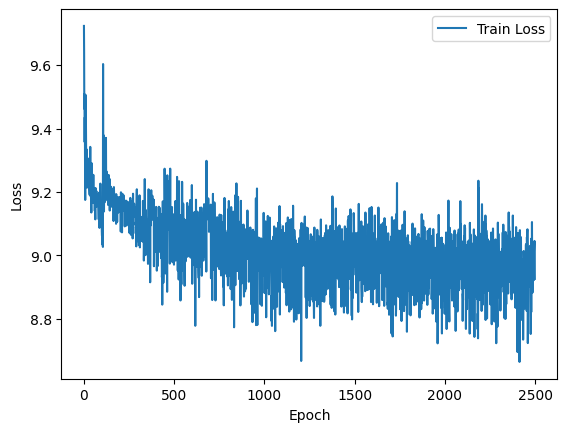

In [32]:
plt.plot(loss_list, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 6. 새로운 모델 평가

In [33]:
new_model = torch.load('/content/drive/MyDrive/Playdata_Python/final_project/models/kor_eng_dataset/translation_model.pth')
# model.eval()  # 모델을 평가 모드로 설정 (Dropout 및 Batch Normalization을 평가 모드로 설정)

In [36]:
# 원본과 번역본
original_text_list = test_df['원문'][:100].tolist()      # 한글
translated_text_list = test_df['번역문'][:100].tolist()  # 영어

original_text_list[:5], translated_text_list[:5]

(['그들 체면이 말이 아닙니다.',
  '한화의 공격력이 나아지지 않는다면 지난해와 같은 성적은 기대하기 어렵다.',
  '오프라인 프로그램에서는 창의적 사고기법과 문제해결방법, 의사소통 능력과 협업능력 등 21세기 미래사회가 요구하는 창의성과 인성 관련 교육이 제공될 예정이다.',
  '행사에는 유주현 대한건설협회 회장을 비롯해 최영묵 건설공제조합 이사장, 임영헌 대한건설협회 사회공헌사업추진위원회 위원장, 이상호 한국건설산업연구원장 등 100여명이 참석했다.',
  '이들은 데이터 무제한 요금제가 있다는 것에 놀랐다.'],
 ['They ought to be ashamed of their reputation.',
  "If Hanwha's offense doesn't improve, it's hard to expect the same performance as last year.",
  'In the offline program, creativity and character-related education required for the future society of the 21st century will be provided, including creative thinking techniques, problem solving methods, communication skills and ability to collaborate.',
  "More than 100 people attended the event, including the chairman of the Construction Association of Korea Yoo Joo-hyun, Chairman of the Construction Guarantee Cooperative Choi Young-muk, Chairman of the Construction Association of Korea's Committee for Promotion of Social Contribution Projects L

In [37]:
# 한글 텍스트를 토큰화하고 번역된 결과를 리스트에 저장하는 테스트
translated_kor_to_eng_list = []

for korean in original_text_list:
    input_ids = tokenizer.encode(korean, return_tensors="pt", max_length=1024, truncation=True)
    translated_ids = new_model.generate(input_ids, num_beams=4, max_length=150, early_stopping=True)
    translated_text = tokenizer.decode(translated_ids[0], skip_special_tokens=True)
    translated_kor_to_eng_list.append(translated_text)

translated_kor_to_eng_list[:5]

AttributeError: ignored

In [ ]:
# 두 개의 문장 (원본 및 번역본)을 가져와서 BLEU 점수 계산
def calculate_bleu_score(original_text, translated_text):
    # 토큰으로 분할
    original_tokens  = original_text.split()
    translated_tokens = translated_text.split()

    # BLEU 점수 계산
    bleu_score = sentence_bleu([original_tokens], translated_tokens)

    return bleu_score

- "Corpus BLEU"는 전체 문서나 대화에 대한 번역 품질을 평가하는 데 사용
- "Sentence BLEU"는 개별 문장에 대한 번역 품질을 평가하는 데 사용


In [ ]:
translated_text_list[0].split()

['They', 'ought', 'to', 'be', 'ashamed', 'of', 'their', 'reputation.']

In [ ]:
translated_kor_to_eng_list[0].split()

['They', "don't", 'look', 'like', 'themselves.']

In [ ]:
# BLEU 점수 계산
num_sentences = 100  # 100개로 test함으로 범위를 100으로 지정
total_belu_score = []

for i in range(num_sentences):

    # Reference 문장과 Candidate 문장 토큰화
    reference_tokens = translated_text_list[i].split()
    candidate_tokens = translated_kor_to_eng_list[i].split()


    # # 2-gram 가중치 설정
    # weights = (0.5, 0.5)  # 2-gram 가중치

    # 3-gram 가중치 설정
    weights = (1/3, 1/3, 1/3)  # 3-gram 가중치

    # BLEU Score 계산
    bleu_score = sentence_bleu(reference_tokens, candidate_tokens, weights=weights)  # (원본 번역문, 모델 번역문)
    total_belu_score.append(bleu_score)

    if i < 20:
        # BLEU 점수 출력
        print(f"{i}번째 원본 번역본: {translated_text_list[i]}")
        print(f"{i}번째 모델 번역본: {translated_kor_to_eng_list[i]}")
        print(f"{i}번째 BLEU 점수: {bleu_score}")
        print("----------------------------------------------------------------------------------------------------")
    else:
        pass

# 전체 blue 평균 계산
average_bleu_score = sum(total_belu_score) / num_sentences
print(f"100문장에 대한 Belu Score 평균: {average_bleu_score}")

0번째 원본 번역본: They ought to be ashamed of their reputation.
0번째 모델 번역본: They don't look like themselves.
0번째 BLEU 점수: 0
----------------------------------------------------------------------------------------------------
1번째 원본 번역본: If Hanwha's offense doesn't improve, it's hard to expect the same performance as last year.
1번째 모델 번역본: It's hard to expect grades like last year unless the damage to Korean currency is getting better.
1번째 BLEU 점수: 0
----------------------------------------------------------------------------------------------------
2번째 원본 번역본: In the offline program, creativity and character-related education required for the future society of the 21st century will be provided, including creative thinking techniques, problem solving methods, communication skills and ability to collaborate.
2번째 모델 번역본: The Offline program will provide creative thinking techniques, problem solving, communication and collaboration, as well as creative and human-related education that will be re

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
